In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, linewidth=100000)
plt.rcParams.update({'font.size': 20})

def re_int(string_sub, string_search):
    return int(re.sub(string_sub, '', re.search(r'%s\d+' % (string_sub), string_search).group()))

def re_float(string_sub, string_search):
    return float(re.sub(string_sub, '', re.search(r'%s[-]?\d+[.]\d+' % (string_sub), string_search).group()))

# hub1d
<div>
<img src="fig/bs_fig_4.png" width="500"/>
</div>

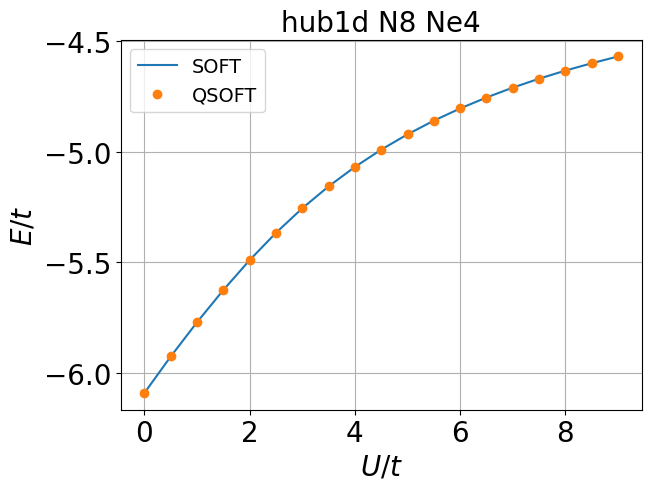

In [2]:
def show_E_U(dir_output, method=['soft', 'qsoft']):
    system, params = dir_output.split('/')[::2]
    marker = ['none', 'o']
    linestyle=['-', 'none']
    
    data = []
    for i, m in enumerate(method):
        data_i = []
        for fn in [fn for fn in os.listdir(dir_output) if re.match(f'{m}_hamiltonian', fn)]:
            data_i.append([re_float('_U', fn), re_float('_e', fn)])
        data_i = np.array(data_i)
        data.append(data_i[data_i[:, 0].argsort()])
    data = np.array(data)

    fig, ax = plt.subplots(constrained_layout=True)
    for d, m, mk, ls in zip(data, method, marker, linestyle):
        ax.plot(d[:, 0], d[:, 1], marker=mk, linestyle=ls, label=f'{m.upper()}')
    ax.set_xlabel(r'$U/t$')
    ax.set_ylabel(r'$E/t$')
    ax.set_title(re.sub('_', ' ', f'{system} {params}'), fontsize='medium')
    ax.legend(fontsize='x-small')
    ax.grid(True)
    plt.show()
    
show_E_U('hub1d/output/N8_Ne4', method=['soft', 'qsoft'])

# hchain
<div>
<img src="fig/bs_fig_5.png" width="500"/>
</div>

method=espresso
N = 8
R = 1.0
dir_output = /home/yerin/qdft/output/N8/espresso_R1.00



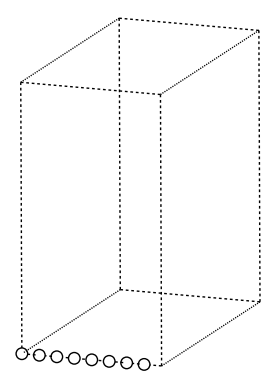

In [3]:
from hchain.lib.dft import DFT
from ase.visualize.plot import plot_atoms

def show_structure(N, R):
    fig, ax = plt.subplots()
    dft = DFT('espresso', N, R, keep_old=True) 
    plot_atoms(dft.structure, ax, rotation=('-15x,20y,-5z'))
    ax.set_axis_off()
    plt.show()

show_structure(8, 1.0)

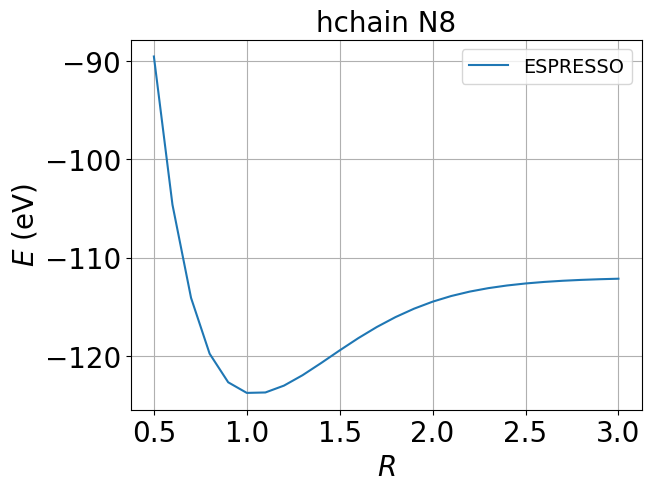

In [31]:
from ase.io import read

def show_E_R(dir_output, method=['vasp', 'espresso', 'qdft']):
    system, params = dir_output.split('/')[::2]
    marker = ['none', 'o']
    linestyle=['-', 'none']
    out_dict = {
        'vasp': 'OUTCAR',
        'espresso': 'espresso.pwo',
    }

    data = []
    for i, m in enumerate(method):
        out = out_dict[m]
        data_i = []
        for dn in [f'{dir_output}/{dn}' for dn in os.listdir(dir_output) if re.match(f'{m}_R', dn)]:
            data_i.append([re_float('_R', dn), read(f'{dn}/{out}').get_total_energy()])
        data_i = np.array(data_i)
        data.append(data_i[data_i[:, 0].argsort()])
    data = np.array(data)

    fig, ax = plt.subplots(constrained_layout=True)
    for d, m, mk, ls in zip(data, method, marker, linestyle):
        ax.plot(d[:, 0], d[:, 1], marker=mk, linestyle=ls, label=f'{m.upper()}')
    ax.set_xlabel(r'$R$')
    ax.set_ylabel(r'$E$ (eV)')
    ax.set_title(re.sub('_', ' ', f'{system} {params}'), fontsize='medium')
    ax.legend(fontsize='x-small')
    ax.grid(True)
    plt.show()

show_E_R('hchain/output/N8', method=['espresso'])

<div>
<img src="fig/bs_eq_15.png" width="500"/>
</div>